In [188]:
import pandas as pd
import numpy as np

In [189]:
annotations_folder = "/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/automated_labeling_experiments/gpt_experiments/annotations"
gpt_pred_folder = "/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/automated_labeling_experiments/gpt_experiments/results"

In [260]:
exp_id = 1
gpt_pred = pd.DataFrame()
annot = pd.DataFrame()
counts = pd.DataFrame()

#class_selection = [["paving_stones", "bad"]]
class_selection = ["paving_stones", "bad"], ["paving_stones", "intermediate"], ["asphalt", "bad"]


for cl in class_selection:
    surface = cl[0]
    smoothness = cl[1]
    if exp_id == 1:
        ds_version = 101
        gpt_results = f"experiment_{exp_id}_V{ds_version}_{surface}_{smoothness}.csv"
    elif exp_id == 2:
        ds_version = 200
        gpt_results = f"experiment_{exp_id}_V{ds_version}_{surface}.csv"
    gpt_temp = pd.read_csv(f"{gpt_pred_folder}/{gpt_results}")
    gpt_pred = pd.concat([gpt_pred, gpt_temp])
    
    total_n = len(gpt_temp)
    gpt_pred_n = len(gpt_temp[(gpt_temp.preselection_type == surface) & (gpt_temp.prediction == smoothness)])
    #counts = pd.concat([counts, pd.Series({"surface": surface, "smoothness": smoothness, "total_n": total_n, "gpt_pred_n": gpt_pred_n})], axis=1)
    counts = pd.concat([counts, pd.Series([exp_id, surface, smoothness, total_n, gpt_pred_n])], axis=1)
    
    file_annot = f"exp{exp_id}_{surface}_{smoothness}_annotations.csv"
    annot_temp = pd.read_csv(f"{annotations_folder}/{file_annot}")
    annot = pd.concat([annot, annot_temp])


counts = counts.T
counts.columns = ["exp", "surface", "smoothness", "total_n", "gpt_pred_n"]
annot["image_id"] = annot.image.apply(lambda x: str.split(x, "/")[-1]).apply(lambda x: int(str.split(x, ".jpg")[0]))
annot.loc[annot.nostreet.notna(), "surface"] = "nostreet"
annot.loc[annot.nostreet.notna(), "smoothness"] = "nostreet"

df = annot[['image_id', 'surface', 'smoothness']].set_index("image_id").join(gpt_pred.set_index('image_id'), on='image_id', how="left").reset_index()
# left join: only keep those with annotations

# true positives
tp = df[(df.preselection_type == df.surface) & (df.prediction == df.smoothness)].groupby(["surface", "smoothness"]).size()
tp.name = "tp"
counts = counts.set_index(["surface", "smoothness"]).join(tp)

In [261]:
#df.groupby(["surface", "smoothness"]).size()

In [262]:
# compute MSE
df["prediction_int"] = df.prediction.apply(lambda x: 
                                           5 if x == "very_bad" 
                                           else 4 if x == "bad" 
                                           else 3 if x == "intermediate" 
                                           else 2 if x == "good" 
                                           else 1 if x == "excellent" 
                                           else None)

df["smoothness_int"] = df.smoothness.apply(lambda x: 
                                           5 if x == "very_bad" 
                                           else 4 if x == "bad" 
                                           else 3 if x == "intermediate" 
                                           else 2 if x == "good" 
                                           else 1 if x == "excellent" 
                                           else None)

In [263]:
from sklearn.metrics import root_mean_squared_error
df_no_na = df[df.smoothness_int.notna() & df.prediction_int.notna()].copy()
df_no_na["squared_error"] = abs(df_no_na.smoothness_int - df_no_na.prediction_int).apply(lambda x: x**2)
rmse = df_no_na.groupby(["preselection_type", "prediction"]).apply(lambda x: root_mean_squared_error(x.smoothness_int, x.prediction_int)).astype(float).round(2)
rmse.name = "rmse"
rmse.index.names = ["surface", "smoothness"]
counts = counts.join(rmse)

In [265]:
import matplotlib.pyplot as plt

def plot_error_hist(df_no_na, surface, smoothness):
    print(f"Class {surface} - {smoothness}")
    temp = df_no_na[(df_no_na.preselection_type == surface) & (df_no_na.prediction == smoothness)]
    plt.hist(temp.squared_error)

Class paving_stones - bad


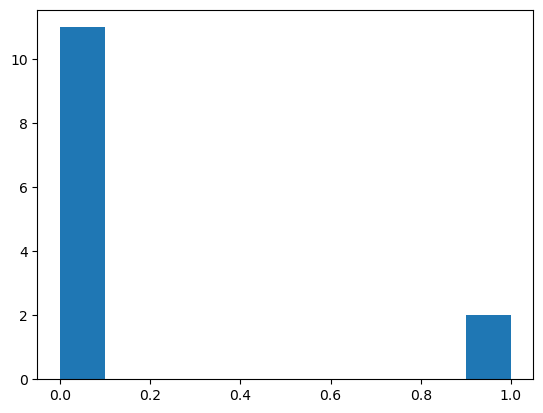

In [266]:
plot_error_hist(df_no_na, "paving_stones", "bad")

Class paving_stones - intermediate


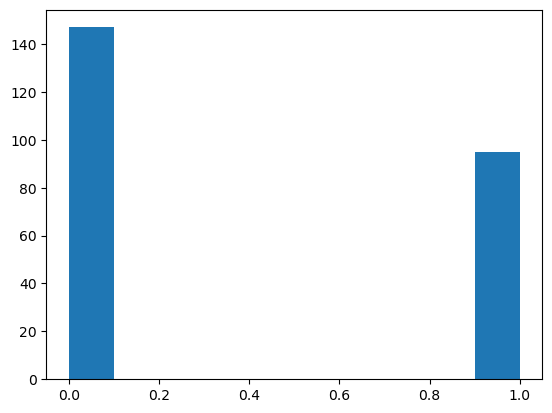

In [267]:
plot_error_hist(df_no_na, "paving_stones", "intermediate")

Class asphalt - bad


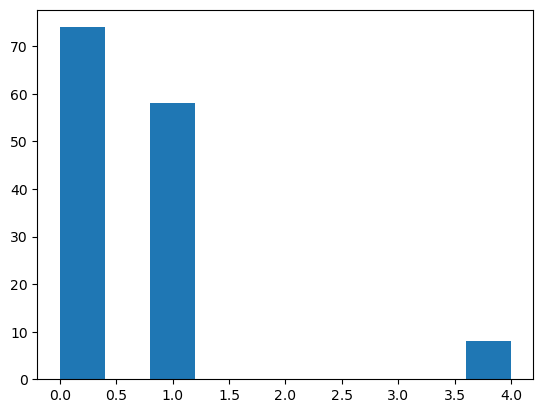

In [268]:
plot_error_hist(df_no_na, "asphalt", "bad")

In [269]:
counts["gpt_precision(tp/n_gpt_pred)"] = (counts.tp / counts.gpt_pred_n).astype(float).round(2)
counts["hit_ratio(tp/n_search_space)"] = (counts.tp / counts.total_n).astype(float).round(2)
counts

exp total_n gpt_pred_n   tp  rmse  \
surface       smoothness                                       
paving_stones bad            1     208         17   11  0.39   
              intermediate   1    1000        340  137  0.63   
asphalt       bad            1    1014        185   73  0.80   

                            gpt_precision(tp/n_gpt_pred)  \
surface       smoothness                                   
paving_stones bad                                   0.65   
              intermediate                          0.40   
asphalt       bad                                   0.39   

                            hit_ratio(tp/n_search_space)  
surface       smoothness                                  
paving_stones bad                                   0.05  
              intermediate                          0.14  
asphalt       bad                                   0.07